In [1]:
import os
import sys
import smbus
import time

from time import sleep
from datetime import datetime

import matplotlib.pyplot as plt

In [2]:
# get current working directory and append relative path for package import
if os.name == 'posix':
    _wd = !pwd
    _wd = _wd[0]
elif os.name == 'nt':
    _wd = !cd
    _wd = _wd[0]
else:
    _wd = os.getcwd()
print('Current working directory is:', _wd)
p = os.path.dirname(_wd)
p = os.path.join(p, '.')
p = os.path.abspath(p)
print('Appending directory to path:', p)
sys.path.insert(0, p)

# alternatively, manually set the path to meerkat
#sys.path.insert(0, '/path_to_meerkat')

Current working directory is: /home/colin/code/meerkat/examples
Appending directory to path: /home/colin/code/meerkat


In [3]:
from meerkat import ads

### Setup ADS1115

In [4]:
i2c = smbus.SMBus(1)
dev = ads.ADS1115(bus=i2c)
dev.get_config()
dev.pga('6.144')  # Other options: '6.144', '4.096'
dev.mux('0G')     # pin 0 relative to ground
dev.get_config()  # refresh for measurements

### Print Status

In [5]:
dev.print_attributes()

ADS11x5 Configuration Attributes
--------------------------------
Config Register: 49539 0xc183 0b1100000110000011
PGA Range: +/- 6.144 Volts
Mode: single
Data Rate: 128 SPS
Input Multiplexer: 0G
Comparator:
 Queue: off
 Latching: off
 Polarity: Active 1
 Mode: trad


In [6]:
def get_time():
    return datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')

### Single Tests

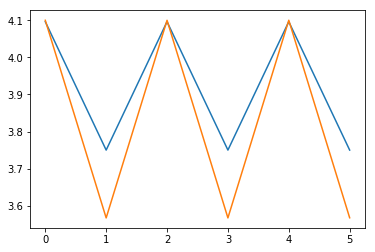

In [7]:
expected = []
actual   = []
# note the 3.75 is an approximation of the resistive load voltage
for i in range(3):
    for j, k in [('0G', 4.096), ('1G', 3.75)]:
        dev.pga('6.144')  # Other options: '6.144', '4.096'
        dev.mux(j)     # pin relative to ground
        Vcc = dev.voltage()
        expected.append(k)
        actual.append(Vcc)
x = range(0, len(actual))
plt.plot(x, expected, x, actual);

In [8]:
print('Measured voltage: {}'.format(dev.voltage()))

Measured voltage: 3.5653125


In [9]:
print(dev.data.writer.create_metadata())

#!{"_file_init": false, "accuracy": null, "bytes": null, "case_sensitive_header": false, "comment": "#", "delimiter": ",", "description": null, "device_metadata": null, "double_quote": true, "dtypes": null, "encoding": "utf-8", "escape_char": "\\", "format": null, "hash": null, "header": ["datetime", "sample_id", "voltage"], "licenses": null, "line_terminator": "\n", "media_type": "text/csv", "name": "ADS1115", "null_sequence": "NA", "path": null, "precision": null, "quote_char": "\"", "schema": null, "shebang": true, "skip_initial_space": true, "skip_lines": 1, "sources": null, "standard": "Follow RFC 4180", "title": null, "units": null, "version": "0.1 Alpha"}


In [10]:
print(dev.data.writer.header)

['datetime', 'sample_id', 'voltage']


In [11]:
print(dev.get(t=get_time(), sid='test'))

['2018-07-12 21:06:29.992968', 'test', 3.5653125]


### File Save Test
LM4040 2.048 V reference source connected to A0

In [12]:
samples = 20

In [13]:
dev.data.writer.path = 'test.csv'
for _ in range(samples):
    dev.write(t=get_time(), sid='test_' + str(_))

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

from meerkat import parser

In [15]:
m, df = parser.csv_resource('test.csv')

### Plot Data

In [16]:
df['datetime64_ns'] = pd.to_datetime(df.datetime)

In [17]:
df.index = df.datetime64_ns

In [18]:
df['rolling_mean'] = df.voltage.rolling(4, win_type='triang').mean()

In [19]:
df_mean = df.voltage.mean()
df['mean'] = df_mean

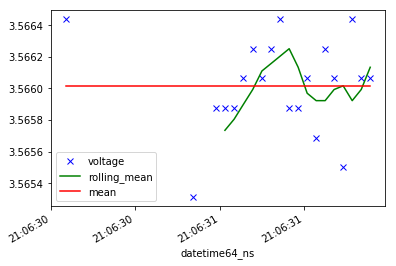

In [20]:
df[['voltage', 'rolling_mean', 'mean']].plot(style=[' xb', '-g', '-r']);

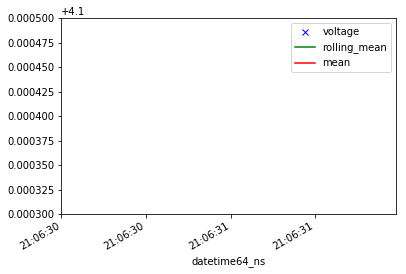

In [21]:
df[['voltage', 'rolling_mean', 'mean']].plot(style=[' xb', '-g', '-r'],
                                             ylim=(4.1003, 4.1005));

In [22]:
print('Mean:', df_mean, 'Volts DC')
print('Standard Deviation:', df.voltage.std())

Mean: 3.566015625 Volts DC
Standard Deviation: 0.000297242673983


In [23]:
dt = df.index[-1]-df.index[0]
dtt = dt.seconds + dt.microseconds / 10**6
print('Sample Rate: {:.4f} Hz'.format(len(df)/dtt))

Sample Rate: 55.5486 Hz


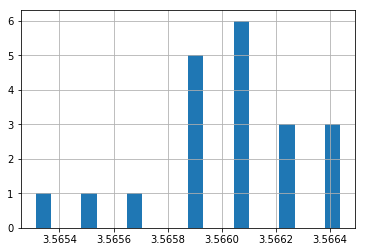

In [24]:
df.voltage.hist(bins=20);

In [25]:
dev.mode('continuous')
dev.get_config()
print('{:b}'.format(dev.config_value))
print(dev.mode_value)

1000000100000000
1


In [26]:
dev.mode('single')
dev.get_config()
print('{:b}'.format(dev.config_value))
print(dev.mode_value)

1000000100000000
1


In [27]:
bin(((dev.config_value & 256) | (dev.str_mode['single'] << 8)))

'0b100000000'

In [28]:
bin(256)

'0b100000000'

In [29]:
bin(dev.config_value)

'0b1000000100000000'

In [30]:
dev.print_attributes()

ADS11x5 Configuration Attributes
--------------------------------
Config Register: 33024 0x8100 0b1000000100000000
PGA Range: +/- 6.144 Volts
Mode: single
Data Rate: 8 SPS
Input Multiplexer: 01
Comparator:
 Queue: 1
 Latching: off
 Polarity: Active 1
 Mode: trad


In [31]:
dev.data_rate(860)

In [32]:
dev.print_attributes()

ADS11x5 Configuration Attributes
--------------------------------
Config Register: 224 0xe0 0b11100000
PGA Range: +/- 6.144 Volts
Mode: single
Data Rate: 860 SPS
Input Multiplexer: 01
Comparator:
 Queue: 1
 Latching: off
 Polarity: Active 1
 Mode: trad


In [33]:
bin(((dev.config_value & 256) | (dev.str_mode['single'] << 8)))

'0b100000000'

In [34]:
bin(((dev.config_value & 256) | (dev.str_mode['continuous'] << 8)))

'0b0'

In [35]:
dev.mode('continuous')

In [36]:
dev.mux('0G')

In [37]:
dev.print_attributes()

ADS11x5 Configuration Attributes
--------------------------------
Config Register: 16384 0x4000 0b100000000000000
PGA Range: +/- 6.144 Volts
Mode: continuous
Data Rate: 860 SPS
Input Multiplexer: 0G
Comparator:
 Queue: 1
 Latching: off
 Polarity: Active 1
 Mode: trad


In [38]:
dev.bin_mode[dev.mode_value]

'continuous'

In [39]:
dev.mode_value

0

In [40]:
dev.mode_value == 0

True

In [41]:
n=10000
t = []
data = []
t0 = time.time()
dt = 1/860
for x in range(n):
    data.append(dev.voltage())
    t.append(time.time())
    time.sleep(dt)
t1 = time.time()
print()
print('Sample Rate {} Hz'.format(n/(t1-t0)))


Sample Rate 508.178063009973 Hz


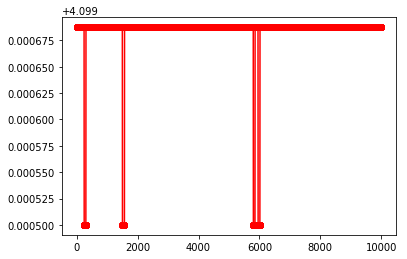

In [42]:
plt.plot(data, 'ro-')

In [44]:
dev.mode('single')

In [45]:
dev.print_attributes()

ADS11x5 Configuration Attributes
--------------------------------
Config Register: 256 0x100 0b100000000
PGA Range: +/- 6.144 Volts
Mode: single
Data Rate: 860 SPS
Input Multiplexer: 0G
Comparator:
 Queue: 1
 Latching: off
 Polarity: Active 1
 Mode: trad


In [46]:
dev.voltage()

4.0996875